📥 Loading FEVER dataset...
✅ Filtered dataset size: 109810
🧹 Preprocessing text...
✅ Cleaned dataset size: 109810
🔀 Splitting into train/test sets...
✅ Train size: 87848, Test size: 21962
🔠 Vectorizing with TF-IDF...
✅ TF-IDF complete.
🚀 Training Logistic Regression model...
✅ Model trained.
📊 Evaluating on test set...

✅ Accuracy: 0.7775

📄 Classification Report:
              precision    recall  f1-score   support

     REFUTES       0.78      0.25      0.38      5955
    SUPPORTS       0.78      0.97      0.86     16007

    accuracy                           0.78     21962
   macro avg       0.78      0.61      0.62     21962
weighted avg       0.78      0.78      0.73     21962



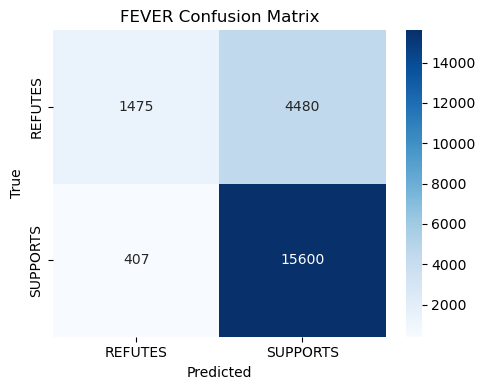

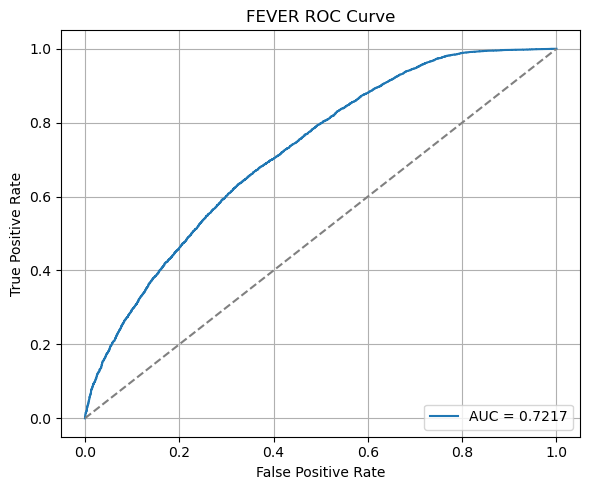

📐 ROC AUC Score: 0.721737
💾 Saving results...
✅ All tasks completed. Results saved.


In [ ]:
# ================================
# FEVER DATASET: Logistic Regression Pipeline (Binary: SUPPORTS vs REFUTES)
# ================================
!pip install pandas numpy scikit-learn openpyxl seaborn matplotlib

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, roc_curve, roc_auc_score
)

# --------------------------
# Text Preprocessing Function
# --------------------------
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# --------------------------
# Load & Prepare FEVER Data
# --------------------------
print("📥 Loading FEVER dataset...")
df = pd.read_excel("../data/filtered_fever_data.xlsx")

# Filter for binary classification: SUPPORTS vs REFUTES only
df = df[df["label"].isin(["SUPPORTS", "REFUTES"])]
df["label"] = df["label"].map({"SUPPORTS": 1, "REFUTES": 0})
print(f"✅ Filtered dataset size: {len(df)}")

# Preprocess text and drop missing
print("🧹 Preprocessing text...")
df["clean_claim"] = df["claim"].apply(preprocess_text)
df = df.dropna(subset=["clean_claim"])
print(f"✅ Cleaned dataset size: {len(df)}")

# --------------------------
# Train-Test Split (80/20)
# --------------------------
print("🔀 Splitting into train/test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_claim"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)
print(f"✅ Train size: {len(X_train)}, Test size: {len(X_test)}")

# --------------------------
# TF-IDF Vectorization
# --------------------------
print("🔠 Vectorizing with TF-IDF...")
vectorizer = TfidfVectorizer(max_features=10000, stop_words="english", ngram_range=(1, 3))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print("✅ TF-IDF complete.")

# --------------------------
# Train Logistic Regression
# --------------------------
print("🚀 Training Logistic Regression model...")
model = LogisticRegression(max_iter=200, n_jobs=-1, random_state=42)
model.fit(X_train_tfidf, y_train)
print("✅ Model trained.")

# --------------------------
# Predictions & Evaluation
# --------------------------
print("📊 Evaluating on test set...")
y_pred = model.predict(X_test_tfidf)
y_prob = model.predict_proba(X_test_tfidf)[:, 1]  # Prob for class 1 (SUPPORTS)

# Accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Accuracy: {accuracy:.4f}")
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["REFUTES", "SUPPORTS"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["REFUTES", "SUPPORTS"], yticklabels=["REFUTES", "SUPPORTS"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("FEVER Confusion Matrix")
plt.tight_layout()
plt.show()

# --------------------------
# ROC Curve & AUC
# --------------------------
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('FEVER ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"📐 ROC AUC Score: {roc_auc:.6f}")

# --------------------------
# Save Results
# --------------------------
print("💾 Saving results...")
report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
report_df.to_excel("LR_FEVER_Classification_Report.xlsx")

results_df = X_test.to_frame(name="claim")
results_df["predicted_label"] = y_pred
results_df["true_label"] = y_test.values
results_df.to_excel("LR_FEVER_Predictions.xlsx", index=False)

print("✅ All tasks completed. Results saved.")
